# **Aprendizaje automático y procesamiento del lenguaje natural**

El aprendizaje automático (ML) ha revolucionado el campo del Procesamiento del Lenguaje Natural (PNL) al permitir que las computadoras comprendan, interpreten y generen lenguaje humano de manera más efectiva. Antes del auge del ML, el PNL se basaba principalmente en reglas lingüísticas codificadas manualmente, lo que resultaba en sistemas frágiles y limitados en su capacidad para manejar la complejidad y la variabilidad del lenguaje natural. Los algoritmos de ML, en cambio, aprenden patrones directamente de grandes cantidades de datos textuales, lo que les permite adaptarse a diferentes estilos de escritura, dialectos y matices semánticos.

El rol del aprendizaje automático en el PNL es multifacético. Se utiliza para una amplia gama de tareas, incluyendo la clasificación de textos (por ejemplo, detección de spam, análisis de sentimiento), la extracción de información (por ejemplo, reconocimiento de entidades nombradas, extracción de relaciones), la traducción automática, el resumen de textos, la respuesta a preguntas y la generación de lenguaje natural (como en chatbots y asistentes virtuales). Los modelos de ML, han demostrado ser particularmente efectivos para abordar problemas complejos de PNL, superando en muchos casos a los enfoques tradicionales basados en reglas y abriendo nuevas posibilidades para la interacción humano-máquina.

## **Tareas supervizadas vs no supervizadas**

En el campo del Procesamiento del Lenguaje Natural (NLP), el aprendizaje supervisado se distingue por utilizar conjuntos de datos etiquetados, donde cada texto o fragmento de texto está asociado a una etiqueta predefinida (por ejemplo, categoría de un documento, sentimiento de una reseña). Esto permite entrenar modelos para predecir dichas etiquetas en nuevos datos, siendo útil para tareas como clasificación de textos, análisis de sentimiento y traducción automática. En contraste, el aprendizaje no supervisado trabaja con datos sin etiquetas, buscando patrones inherentes y estructuras ocultas en el texto. Sus aplicaciones en NLP incluyen el agrupamiento de documentos por similitud temática (clustering), la reducción de la dimensionalidad de representaciones textuales y el descubrimiento de temas latentes en grandes corpus. Mientras que el aprendizaje supervisado requiere la costosa y a veces laboriosa tarea de etiquetar datos, el no supervisado puede revelar información valiosa sin esta necesidad, explorando la estructura intrínseca del lenguaje.

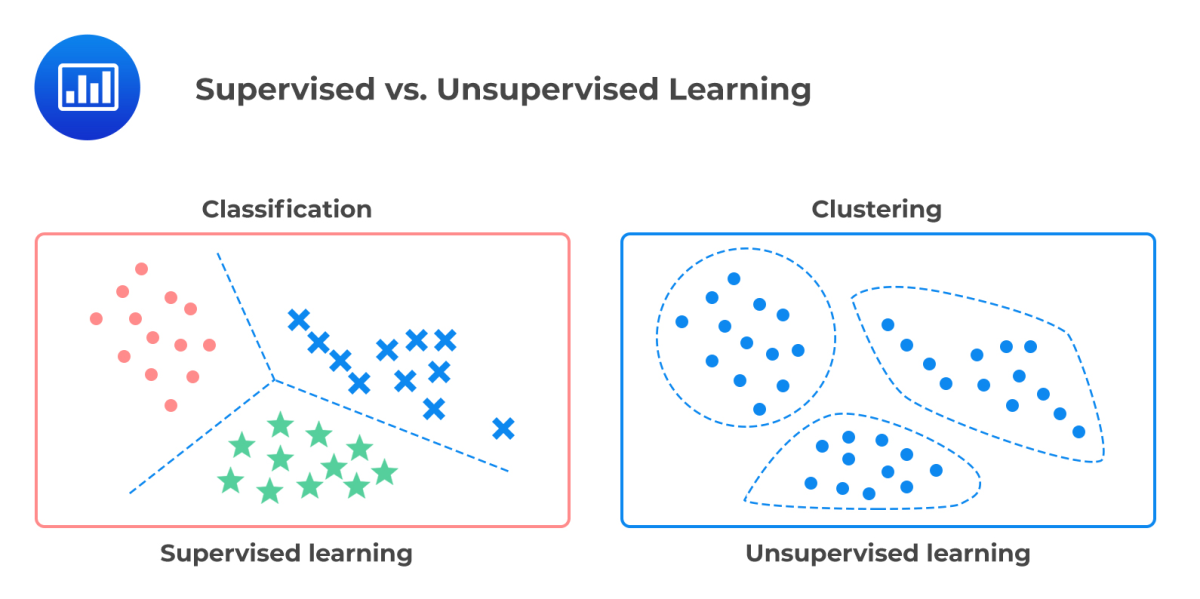

In [1]:
%%capture
!pip install unidecode

In [2]:
from unidecode import unidecode
from sklearn import datasets
import re
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

## **0. Carga de datos**

El conjunto de datos 20 Newsgroups es una colección clásica de aproximadamente 20,000 documentos de grupos de noticias, distribuidos casi equitativamente en 20 categorías temáticas diversas que abarcan desde computación y recreación hasta ciencia y política. Ampliamente utilizado en NLP y aprendizaje automático, este dataset sirve como un punto de referencia para tareas de clasificación de texto, agrupamiento, etc ...

In [5]:
data = datasets.fetch_20newsgroups(subset='all', categories=['sci.med','rec.sport.hockey'])
text = data.data
Y = data.target

print(text[0])
print(Y[0])

From: ad215@Freenet.carleton.ca (Rachel Holme)
Subject: Re: CBC Game Choices (was LA ON CBC...)
Reply-To: ad215@Freenet.carleton.ca (Rachel Holme)
Organization: The National Capital Freenet
Lines: 39


In a previous article, 35002_2765@uwovax.uwo.ca () says:

>In article <boora.735182771@sfu.ca>, boora@kits.sfu.ca (The GodFather) writes:
>> 
>> 	CBC had a great chance for some double headers:  Toronto/Detroit
>> and Vancouver/Winnipeg, but today they said that the East gets the Leafs
>> and the West get the Vancouver game.  I thought that they would show them
>> both.

I'm totally p*-o'd, too!  Vancouver-Winnipeg is great west-coast hockey -
fast-paced and loads of talent.  What I've seen so far is hardly
entertaining, with the exception of the odd shift every now & then (of
course I missed Calgary-LA & Pitts-Jersey...)

>No, because the PINHEADS at CBC figure everyone here in Ontario cares
>for the Leafs, the Maple Leafs, and nothing but the Leafs.  Half of
>Southern Ontario is people

## **1. peprocesamiento de datos**

Ahora usemos una rutina de preprocesamiento para normalizar nuestro corpus.

In [6]:
pat = re.compile(r"[^a-z ]")
spaces = re.compile(r"\s{2,}")
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

def preprocess(text, min_len=1, max_len=23):
    doc = nlp(text)
    # Eliminamos stopwords
    filtered_tokens = [token for token in doc if token.is_stop==False]
    # Filtramos palabras por longitud
    filtered_tokens2 = [token.text for token in filtered_tokens if ((len(token) >= min_len) and (len(token) <= max_len))]
    filtered_text = " ".join(filtered_tokens2)
    # Normalizamos el texto
    norm_text = unidecode(filtered_text)
    # Quitamos grafía
    lower_text = norm_text.lower()
    # Eliminamos caracteres especiales
    clean_text = re.sub(pat, "", lower_text)
    # Eliminamos espacios duplicados
    spaces_text = re.sub(spaces, " ", clean_text)
    return spaces_text.strip()


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:
clean_text = list(map(preprocess, text))
print(clean_text[0])

rachel holme subject cbc game choices la cbc reply rachel holme organization national capital freenet lines previous article says article boorasfuca boorakitssfuca godfather writes cbc great chance double headers toronto detroit vancouver winnipeg today said east gets leafs west vancouver game thought totally pod vancouver winnipeg great west coast hockey fast paced loads talent seen far hardly entertaining exception odd shift course missed calgary la pitts jersey pinheads cbc figure ontario cares leafs maple leafs leafs half southern ontario people moved west good folks toronto care doubleheader heck second game canadian teams let desperate news watch national newsworld canada ends windsor doncha know grrrrr amen updates mins cnn headline news crying loud cheaper phone calls better system ring adams linden scores rings bure rushes ice scores etc etc rachel holme


## **2.  Recordemos: extracción de cracteriticas**

Es hora de que representemos de forma vectorial nuestro texto. Extraiga la representación usando la bolsa de palabras y TF-IDF del corpus, considere usar un vocabulario de máximo 50 tokens. Recuerde que debe particionar los datos con antelación usando un hold-out  (70/15/15).

In [13]:
X_train, X_temp, y_train, y_temp = train_test_split(text, Y, test_size=0.30, random_state=42, stratify=Y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

bow_vectorizer = CountVectorizer(max_features=50, stop_words='english')
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_val_bow = bow_vectorizer.transform(X_val)
X_test_bow = bow_vectorizer.transform(X_test)

# --- BoW ---
bow_vectorizer = CountVectorizer(max_features=50, stop_words='english')
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_val_bow = bow_vectorizer.transform(X_val)
X_test_bow = bow_vectorizer.transform(X_test)

# --- TF-IDF ---
tfidf_vectorizer = TfidfVectorizer(max_features=50, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

#Explicación del codigo anterior.

## 🧠 Representación vectorial de texto: BoW vs TF-IDF

Este código convierte documentos de texto en representaciones numéricas utilizando dos métodos diferentes: **Bolsa de Palabras (BoW)** y **TF-IDF**, limitando el vocabulario a las 50 palabras más frecuentes.

---

### 📦 Bolsa de Palabras (BoW)

```python
from sklearn.feature_extraction.text import CountVectorizer

# Crear el vectorizador BoW
bow_vectorizer = CountVectorizer(max_features=50, stop_words='english')

# Ajustar con datos de entrenamiento y transformar
X_train_bow = bow_vectorizer.fit_transform(X_train)

# Transformar conjuntos de validación y prueba
X_val_bow = bow_vectorizer.transform(X_val)
X_test_bow = bow_vectorizer.transform(X_test)



from sklearn.feature_extraction.text import TfidfVectorizer

# Crear el vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=50, stop_words='english')

# Ajustar con datos de entrenamiento y transformar
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transformar conjuntos de validación y prueba
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


## 🤔 ¿Por qué a veces usamos `fit` y otras veces no?

### 🔹 `fit()`: solo con el conjunto de **entrenamiento**
```python
vectorizer.fit(X_train)




Este bloque se verá correctamente si lo pegas tal cual en una celda Markdown en Jupyter. ¿Te gustaría que hiciera una versión visual (como diapositiva) o que agregue ejemplos con tus datos reales (`X_train`, etc.)?


## **3.  regresión logistica con la bolsa de palabras**

La regresión logística es un algoritmo de clasificación que predice la probabilidad de una variable categórica utilizando una función sigmoide para transformar una combinación lineal de las variables independientes en un valor entre 0 y 1. Este valor representa la probabilidad de que la instancia pertenezca a una clase específica, comúnmente utilizada en problemas de clasificación binaria donde el objetivo es determinar a cuál de dos categorías pertenece una observación, encontrando los coeficientes óptimos a través de la minimización de la entropía cruzada.








In [20]:
for c in[0.1, 0.001, 0.0001, 0.00001]:
  model = LogisticRegression(C=c)
  model.fit(X_train_bow, y_train)
  print(f'C:{c} give accuracy:{model.score(X_val_bow, y_val)}')

C:0.1 give accuracy:0.9295302013422819
C:0.001 give accuracy:0.889261744966443
C:0.0001 give accuracy:0.8657718120805369
C:1e-05 give accuracy:0.8087248322147651


Ahora evaluemos finalmente el modelo

In [21]:
model = LogisticRegression(C=0.1)
model.fit(X_train_bow, y_train)
pred = model.predict(X_test_bow)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94       150
           1       0.91      0.98      0.94       149

    accuracy                           0.94       299
   macro avg       0.95      0.94      0.94       299
weighted avg       0.95      0.94      0.94       299



## **4.  Evalue el uso del metodo TD-IDF junto a la regresión logistica**

Evalúe la interacción entre la representación TF-IDF en conjunto a la regresión logística

In [25]:
# Crear el vectorizador TF-IDF y ajustar a los datos de entrenamiento
tfidf_vectorizer = TfidfVectorizer(max_features=50, stop_words='english')

# Transformar los datos
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

for c in[0.1, 0.001, 0.0001, 0.00001]:
  model = LogisticRegression(C=c)
  model.fit(X_train_tfidf, y_train)
  print(f'C:{c} give accuracy:{model.score(X_val_bow, y_val)}')

# Evaluar en el conjunto de validación
y_val_pred = model.predict(X_val_tfidf)
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Evaluar en el conjunto de prueba
y_test_pred = model.predict(X_test_tfidf)
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))

C:0.1 give accuracy:0.87248322147651
C:0.001 give accuracy:0.8590604026845637
C:0.0001 give accuracy:0.7986577181208053
C:1e-05 give accuracy:0.5167785234899329

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67       150
           1       0.00      0.00      0.00       148

    accuracy                           0.50       298
   macro avg       0.25      0.50      0.33       298
weighted avg       0.25      0.50      0.34       298


Test Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67       150
           1       0.00      0.00      0.00       149

    accuracy                           0.50       299
   macro avg       0.25      0.50      0.33       299
weighted avg       0.25      0.50      0.34       299



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m